# Examen Final: CC521 A Programación Evolutiva 2022-1
Alumno: Jordi Joel Bardales Rojas

### 1. Descripción del problema
El problema del vendedor viajero, problema del vendedor ambulante, problema del agente viajero o problema del viajante (TSP por sus siglas en inglés (Travelling Salesman Problem)), responde a la siguiente pregunta: dada una lista de ciudades y las distancias entre cada par de ellas, ¿cuál es la ruta más corta posible que visita cada ciudad exactamente una vez y al finalizar regresa a la ciudad origen?


El cuaderno (Google Colab Notebook) adjunto contiene el código para dicho problema, el trabajo consiste en:

In [ ]:
from __future__ import annotations
import random
from enum import Enum
import matplotlib.pyplot as plt
from typing import Callable, List, NamedTuple, Tuple
import copy
import numpy as np
import math
from abc import ABC, abstractmethod
import warnings
warnings.filterwarnings('ignore')

##### Algoritmo TSP

In [ ]:
N_CITIES = 20  # DNA size
CROSS_RATE = 0.1
MUTATE_RATE = 0.02
POP_SIZE = 500
N_GENERATIONS = 100

In [ ]:
class GA(object):
    def __init__(self, DNA_size: int, cross_rate: float, mutation_rate: float, pop_size: int):
        self.DNA_size = DNA_size
        self.cross_rate = cross_rate
        self.mutate_rate = mutation_rate
        self.pop_size = pop_size
        # crea un poblacion con permutaciones random de longitud DNA_size
        self.pop = np.vstack([np.random.permutation(DNA_size) for _ in range(pop_size)])

    def translateDNA(self, DNA: np.ndarray, city_position: np.ndarray):
        # obtiene las coordenadas de las ciudades en orden
        line_x = np.empty_like(DNA, dtype=np.float64)
        line_y = np.empty_like(DNA, dtype=np.float64)
        for i, d in enumerate(DNA):
            city_coord = city_position[d]
            line_x[i, :] = city_coord[:, 0]
            line_y[i, :] = city_coord[:, 1]
        return line_x, line_y

    def get_fitness(self, line_x: np.ndarray, line_y: np.ndarray):
        # fitness es la distancia eucledianda de las coordenadas de la ciudad
        total_distance = np.empty((line_x.shape[0],), dtype=np.float64)
        for i, (xs, ys) in enumerate(zip(line_x, line_y)):
            total_distance[i] = np.sum(np.sqrt(np.square(np.diff(xs)) + np.square(np.diff(ys))))
        fitness = np.exp(self.DNA_size * 2 / total_distance)
        return fitness, total_distance

    def select(self, fitness: np.ndarray):
        idx = np.random.choice(np.arange(self.pop_size), size=self.pop_size, replace=True, p=fitness / fitness.sum())
        return self.pop[idx]

    def crossover(self, parent: np.ndarray, pop: np.ndarray):
        # probabilidad de que un individuo se cruce
        if np.random.rand() < self.cross_rate:
            # selecciona otro individuo de la población para el cruce
            i_ = np.random.randint(0, self.pop_size, size=1)
            # elige una máscada de [True, False] de los puntos que serán cruzados
            cross_points = np.random.randint(0, 2, self.DNA_size).astype(np.bool)
            # encuentra el número de la ciudad, mantenemos aquellos que serán que tienen False, es decir, son ciudades que no son cruzadas.
            keep_city = parent[~cross_points]
            # ravel [[1, 2]] = [1, 2], del elemento i, seleccionamos aquella que coinciden con el padre, e intercambiamos, esto con el fin de evitar elementos repetidos
            swap_city = pop[i_, np.isin(pop[i_].ravel(), keep_city, invert=True)]
            # el padre es reemplazado
            parent[:] = np.concatenate((keep_city, swap_city))
        return parent

    def mutate(self, child):
        # para cada cada ciudad de la cadena
        for point in range(self.DNA_size):
            # esta se se muta con una cierta probabilidad
            if np.random.rand() < self.mutate_rate:
                # se intercambia con otra ciudad de la cadena
                swap_point = np.random.randint(0, self.DNA_size)
                swapA, swapB = child[point], child[swap_point]
                child[point], child[swap_point] = swapB, swapA
        return child

    def evolve(self, fitness, fnSelect=None, fnCrossover=None, fnMutation=None):
        # algoritmo genetico
        # seleccion de padres proporcional al fitness
        pop = self.select(fitness) if fnSelect == None else fnSelect(self, fitness)
        # copia temporal de la poblacion
        pop_copy = pop.copy()
        # cada padre seleccionado
        for parent in pop:
            # se elige otro individuo de la población para el cruce
            child = self.crossover(parent, pop_copy)
            # se muta cada ciudad con una cierta probabilidad utilizando swap
            child = self.mutate(parent) if fnMutation == None else fnMutation(self, parent)
            # hijo reemplaza al padre
            parent[:] = child
        self.pop = pop


In [ ]:
class TravelSalesPerson(object):
    def __init__(self, n_cities):
        # la posición de cada ciudad es aleatioria
        self.city_position = np.random.rand(n_cities, 2)
        plt.ion()

    def plotting(self, lx, ly, total_d, title=""):
        plt.cla()
        plt.title(title)
        # dibujamos los puntos en la ciudad
        plt.scatter(self.city_position[:, 0].T, self.city_position[:, 1].T, s=100, c='k')
        plt.plot(lx.T, ly.T, 'r-')
        plt.text(-0.05, -0.05, "Total distance=%.2f" % total_d, fontdict={'size': 20, 'color': 'red'})
        plt.xlim((-0.1, 1.1))
        plt.ylim((-0.1, 1.1))
        plt.pause(0.01)

Gen: 0 | best fit: 333.78


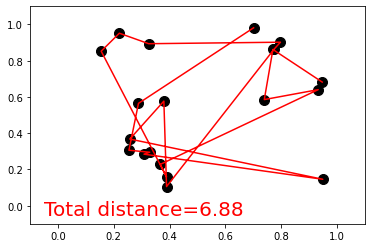

Gen: 11 | best fit: 2342.99


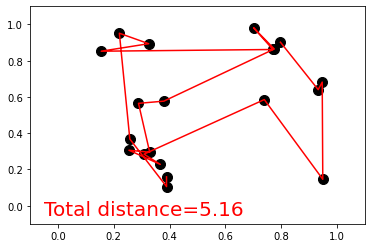

Gen: 22 | best fit: 21020.46


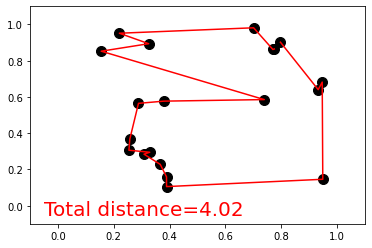

Gen: 33 | best fit: 34023.23


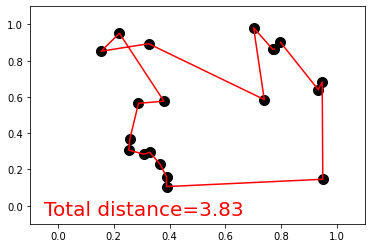

Gen: 44 | best fit: 173890.67


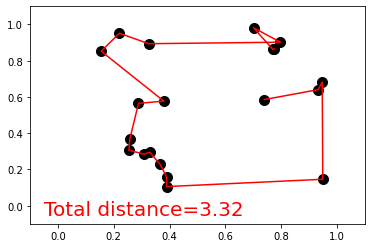

Gen: 55 | best fit: 342010.39


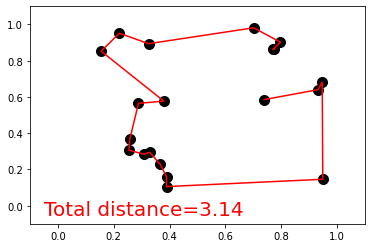

Gen: 66 | best fit: 348548.03


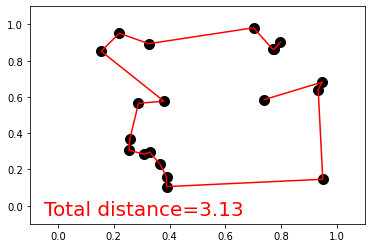

Gen: 77 | best fit: 368367.95


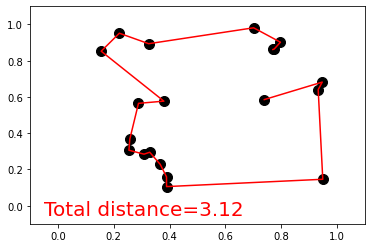

Gen: 88 | best fit: 368367.95


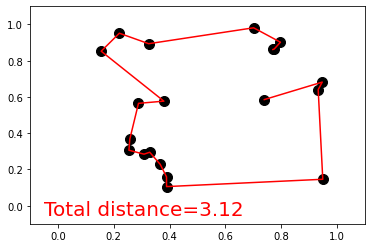

Gen: 99 | best fit: 368367.95


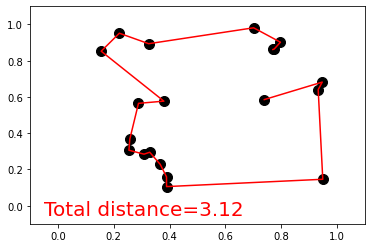

In [ ]:
ga = GA(DNA_size=N_CITIES, cross_rate=CROSS_RATE, mutation_rate=MUTATE_RATE, pop_size=POP_SIZE)

env = TravelSalesPerson(N_CITIES)
for generation in range(N_GENERATIONS):
    # obtiene las coordenadas de las ciudades en orden a la posicion de la ciudad
    lx, ly = ga.translateDNA(ga.pop, env.city_position)
    # calcula el fitness
    fitness, total_distance = ga.get_fitness(lx, ly)
    ga.evolve(fitness = fitness,
              fnSelect=None,
              fnCrossover=None,
              fnMutation=None)
    best_idx = np.argmax(fitness)
    if generation % 11 == 0:
        print('Gen:', generation, '| best fit: %.2f' % fitness[best_idx],)
        env.plotting(lx[best_idx], ly[best_idx], total_distance[best_idx])

plt.ioff()
plt.show()


### 1. Basado en el código adjunto, diseñe un algoritmo que optimice el algoritmo aplicando el concepto de ajuste de parámetros. [5 puntos]
**Solución**

El algoritmo genetico del TSP posee lo siguiente:
- La cadena está formada una permutación de ciudades, el cual representa el orden en que son visitadas.
- La selección de padres es proporcional al fitness.
- El cruzamiento por intercambio de ciudades, es decir, para cada padre seleccionado, con una cierta probabilidad para el cruzamiento, se elige otro padre de forma aleatoria de la población e intercambian de forma aletoria aquellas ciudades comunes que possen, esto con el fin de tener ciudades duplicadas.
- La mutacion, se recorre toda la cadena y se intercambia con una cierta probabilidad otra ciudad de la misma cadena de forma aleatoria.

Se propone ajustar los siguientes parámetros:
- Tamaño de la población
- Probabilidad de cruzamiento
- Probabilidad de mutación

**Algoritmo**

```
combinacion_optima = []
max_utilidad = []
Para cada combinacion de hiperparámetros:
    Seleccionar de forma aleatoria el tamaño de la población, probabilidad de cruzamiento y probabilidad de mutación en sus respectivos intervalos.
    Para la combinación i realizar 10 pruebas con diferente población aleatorio # stadistica
        Generar población con la combinación de parámetros i-esima
        Iniciar el algoritmo genetico con N_CITIES ciudades
            Para la generacion k
                Obtener el menor fitness a partir de la generación t y almacenar en el arreglo collect_offline
        Promediar collect_offline (promedio de mejores)
	  Almacenar la funcion de utilidad en el arreglo offline_stat
    Promediar offline_stat, funciones de utilidad offline # estadistica  
    Si el promedio de offline_stat es mejor que max_utilidad
        Asignar esta combinacion a combinacion_optima
        Asignar esta utilidad a max_utilidad	  
```
La implementación de este algoritmo está en la pregunta 3

### 2. Implemente el programa para 4 Algoritmos genéticos diferentes y que seleccione el mejor de ellos (evaluar para el mismo conjunto de parámetros numéricos del código adjunto). [3 puntos]

**Solución**

Se eligirán dos métodos de selección y dos métodos de mutación. El cruzamiento es el mismo. Se modificará el algoritmo genético para que utilice una función de utilidad `offline`, que consiste en seleccionar a partir de la generación $t$ los mejores individuos de cada generación (menor fitness) y obtener el promedio de ellos (promedio de mejores). Los métodos de selección serán Selección Proporcianal y Selección por Torneo y los de mutación Swap y Scramble. 


Seleccion

In [ ]:
def select_proporcional(obj: GA, fitness: np.ndarray):
    # seleccion proporcional al fitness
    idx = np.random.choice(np.arange(obj.pop_size), size=obj.pop_size, replace=True, p=fitness / fitness.sum())
    return obj.pop[idx]


def select_ranking(obj: GA, fitness: np.ndarray):
    mu = obj.pop_size
    s = 1.5
    pop_fit = zip(obj.pop, fitness)
    sorted_pop_fit = sorted(pop_fit, key=lambda val: val[1])
    pop_fit = list(zip(*sorted_pop_fit))
    distribution = [(2 - s) / mu + 2 * i * (s - 1) / (mu * (mu - 1)) for i in range(mu)]
    idx = np.random.choice(np.arange(obj.pop_size), size=obj.pop_size, replace=True, p=distribution)
    return obj.pop[idx]


def select_tournament(obj: GA, fitness: np.ndarray):
    pop_fit_zipped = list(zip(obj.pop, fitness))
    tournament_size = int(obj.pop_size * 0.01)
    selected: list[int] = []
    for _ in range(obj.pop_size):
        candidates = random.choices(pop_fit_zipped, k=tournament_size)
        selected.append(max(candidates, key=lambda pop_fit: pop_fit[1])[0])
    return np.array(selected)


Cruzamiento

In [ ]:
def crossover_swap(obj: GA, parent: np.ndarray, pop: np.ndarray):
    if np.random.rand() < obj.cross_rate:
        # selecciona otro individuo de la población para el cruce
        i_ = np.random.randint(0, obj.pop_size, size=1)
        # elige una máscada de [True, False] de los puntos que serán cruzados
        cross_points = np.random.randint(0, 2, obj.DNA_size).astype(np.bool)
        # encuentra el número de la ciudad, mantenemos aquellos que serán que tienen False, es decir, son ciudades que no son cruzadas.
        keep_city = parent[~cross_points]
        # ravel [[1, 2]] = [1, 2], del elemento i, seleccionamos aquella que coinciden con el padre, e intercambiamos, esto con el fin de evitar elementos repetidos
        swap_city = pop[i_, np.isin(pop[i_].ravel(), keep_city, invert=True)]
        # el padre es reemplazado
        parent[:] = np.concatenate((keep_city, swap_city))
    return parent


Mutación

In [ ]:
def mutate_swap(obj: GA, child):
    # para cada cada ciudad de la cadena
    for point in range(obj.DNA_size):
        # esta se se muta con una cierta probabilidad
        if np.random.rand() < obj.mutate_rate:
            # se intercambia con otra ciudad de la cadena
            swap_point = np.random.randint(0, obj.DNA_size)
            swapA, swapB = child[point], child[swap_point]
            child[point], child[swap_point] = swapB, swapA
    return child


def mutate_invert(obj: GA, child):
    # 1 2 3 4 5 6 7 8 9 0 -> 1 2 6 5 4 3 7 8 9 0
    if np.random.rand() < obj.mutate_rate:
        point = np.random.randint(0, obj.DNA_size - 5)
        child[point: point + 5] = list(reversed(child[point: point + 5]))
    return child


def mutate_scramble(obj: GA, child):
    # 1 2 3 4 5 6 7 8 9 0 -> 1 2 6 5 4 3 7 8 9 0
    if np.random.rand() < obj.mutate_rate:
        point = np.random.randint(0, obj.DNA_size - 5)
        child[point: point + 5] = np.random.choice(child[point: point + 5], replace=False, size=5)
    return child


In [ ]:
selection = [select_proporcional, select_tournament]
mutate = [mutate_swap, mutate_scramble]


In [ ]:
collect_mean_offline = []
combinacion_optima_ev = [0] * 3
max_utilidad = -np.Inf
count = 0
for sel in selection:
    for mut in mutate:
        print(f"Combinación {count}: {sel.__name__}, {mut.__name__}")
        ga = GA(DNA_size=N_CITIES, cross_rate=CROSS_RATE, mutation_rate=MUTATE_RATE, pop_size=POP_SIZE)
        # se eligiran los 10 ultimos
        t = N_GENERATIONS - 10
        env = TravelSalesPerson(N_CITIES)
        collect_offline: list[float] = []
        for generation in range(N_GENERATIONS):
            # obtiene las coordenadas de las ciudades en orden a la posicion de la ciudad
            lx, ly = ga.translateDNA(ga.pop, env.city_position)
            # calcula el fitness
            fitness, total_distance = ga.get_fitness(lx, ly)
            ga.evolve(fitness=fitness,
                      fnSelect=sel,
                      fnCrossover=None,
                      fnMutation=mut)
            best_idx = np.argmax(fitness)
            if generation % 11 == 0:
                print('Gen:', generation, '| best fit: %.2f' % fitness[best_idx],)
            if generation >= t:
                # seleccionamos el mejor fitness
                collect_offline.append(min(fitness))
        mean_offline = sum(collect_offline) / len(collect_offline)
        if mean_offline > max_utilidad:
            max_utilidad = mean_offline
            combinacion_optima_ev = [count, sel, mut]
        collect_mean_offline.append(sum(collect_offline) / len(collect_offline))
        count += 1
print(f"Combinación óptima\n{combinacion_optima_ev[1].__name__}, {combinacion_optima_ev[2].__name__}")


Combinación 0: select_proporcional, mutate_swap
Gen: 0 | best fit: 276.87
Gen: 11 | best fit: 1080.85
Gen: 22 | best fit: 5298.80
Gen: 33 | best fit: 29659.52
Gen: 44 | best fit: 70566.49
Gen: 55 | best fit: 72019.03
Gen: 66 | best fit: 89115.99
Gen: 77 | best fit: 101660.50
Gen: 88 | best fit: 111327.49
Gen: 99 | best fit: 111327.49
Combinación 1: select_proporcional, mutate_scramble
Gen: 0 | best fit: 203.30
Gen: 11 | best fit: 498.37
Gen: 22 | best fit: 903.40
Gen: 33 | best fit: 903.40
Gen: 44 | best fit: 903.40
Gen: 55 | best fit: 932.82
Gen: 66 | best fit: 932.82
Gen: 77 | best fit: 932.82
Gen: 88 | best fit: 932.82
Gen: 99 | best fit: 932.82
Combinación 2: select_tournament, mutate_swap
Gen: 0 | best fit: 683.53
Gen: 11 | best fit: 18015.49
Gen: 22 | best fit: 46631.45
Gen: 33 | best fit: 92130.30
Gen: 44 | best fit: 147600.99
Gen: 55 | best fit: 150111.71
Gen: 66 | best fit: 150111.71
Gen: 77 | best fit: 150111.71
Gen: 88 | best fit: 150111.71
Gen: 99 | best fit: 150111.71
Comb

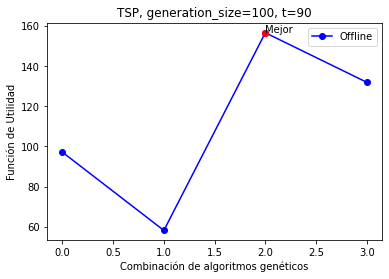

In [ ]:
plt.xlabel("Combinación de algoritmos genéticos")
plt.ylabel("Función de Utilidad")
# plt.plot(range(len(population_size)), online, 'o-', label="Online")
plt.title("TSP, generation_size=%d, t=%d" % (N_GENERATIONS, t))
# axes.plot(online, 'o-', label="Online", c="b")
plt.plot(collect_mean_offline, 'o-', label="Offline", c="b")
plt.plot(combinacion_optima_ev[0], max_utilidad, 'o', c='r')
plt.annotate(str("Mejor"), (combinacion_optima_ev[0], max_utilidad))
plt.legend()
plt.show()


Gen: 0 | best fit: 643.17


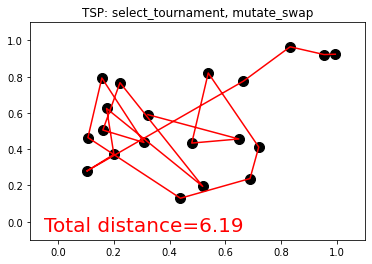

Gen: 11 | best fit: 38783.08


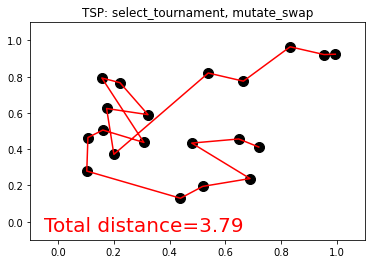

Gen: 22 | best fit: 137182.42


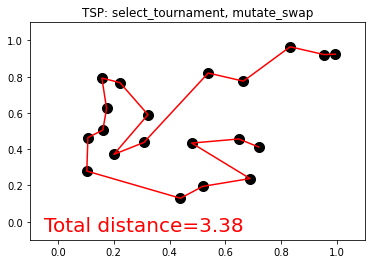

Gen: 33 | best fit: 233011.22


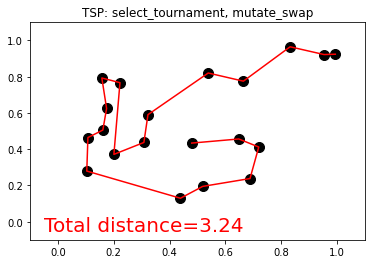

Gen: 44 | best fit: 233011.22


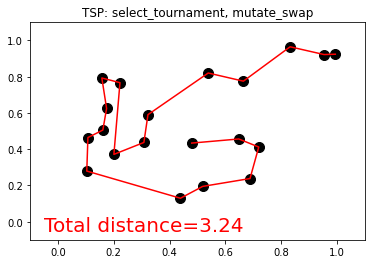

Gen: 55 | best fit: 233011.22


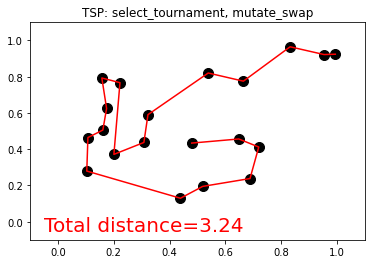

Gen: 66 | best fit: 233011.22


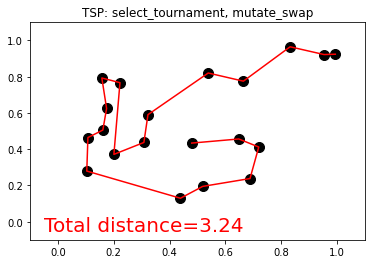

Gen: 77 | best fit: 233011.22


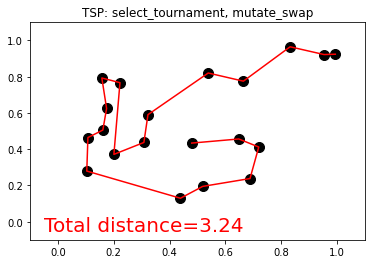

Gen: 88 | best fit: 233011.22


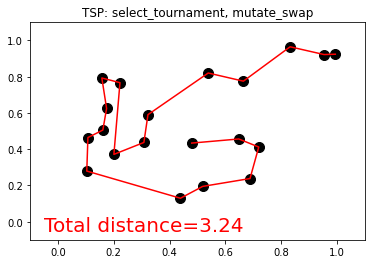

Gen: 99 | best fit: 233011.22


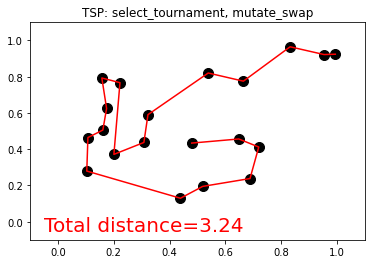

In [ ]:
ga = GA(DNA_size=N_CITIES, cross_rate=CROSS_RATE, mutation_rate=MUTATE_RATE, pop_size=POP_SIZE)

env = TravelSalesPerson(N_CITIES)
for generation in range(N_GENERATIONS):
    # obtiene las coordenadas de las ciudades en orden a la posicion de la ciudad
    lx, ly = ga.translateDNA(ga.pop, env.city_position)
    # calcula el fitness
    fitness, total_distance = ga.get_fitness(lx, ly)
    ga.evolve(fitness=fitness,
              fnSelect=combinacion_optima_ev[1],
              fnCrossover=None,
              fnMutation=combinacion_optima_ev[2])
    best_idx = np.argmax(fitness)
    if generation % 11 == 0:
        print('Gen:', generation, '| best fit: %.2f' % fitness[best_idx],)
        env.plotting(lx[best_idx], ly[best_idx], total_distance[best_idx], f"TSP: {combinacion_optima_ev[1].__name__}, {combinacion_optima_ev[2].__name__}")
plt.ioff()
plt.show()


### 3. Realice la optimización de los parámetros numéricos del mejor algoritmo genético de la pregunta anterior, aplicando el criterio de diseño y ajuste de parámetros, considerar una estadística de acuerdo a la demora de cada ejecución. [7 puntos]


In [ ]:
CROSS_RATE = 0.1
MUTATE_RATE = 0.02
POP_SIZE = 500

Los parámetros a optimizar son el el tamaño de la población, ratio de cruzamiento y ratio de mutación. El criterio de selección de parámetros es de forma aleatoria.
- El tamaño de la población estará en el intervalo [250, 550]
- La probabilidad de cruzamiento estará en el intervalo [0.1, 0.7] 
- La probabilidad de mutación estará en el intervalo [0.01, 0.05]

Para un total de 20 combinaciones, en el cada combinación tendrá una estadística de 10 pruebas.

In [ ]:
GENERACIONES = 50
# para el promedio de los últimos 20 individuos
t = GENERACIONES - 20
# 30 combinaciones de parámetros
NRO_COMBINACIONES = 20
# estadística
STATISTICS_SIZE = 10

combinacion_optima = [0] * 4
max_utilidad = -np.Inf
stats_fu = []
count = 0
# Para cada combinacion de hiperparámetros
for i in range(NRO_COMBINACIONES):
    # Seleccionar de forma aleatoria el tamaño de la población, probabilidad de cruzamiento y probabilidad de mutación en sus respectivos intervalos.
    population_size = random.randint(250, 550)
    crossover_rate = random.uniform(0.1, 0.7)
    mutation_rate = random.uniform(0.01, 0.05)

    print(f"Combinación {count}: ({population_size}, {crossover_rate}, {mutation_rate})")
    offline_stat = []
    # Para la combinación i realizar 10 pruebas con diferente población aleatoria # stadistica
    for _ in range(STATISTICS_SIZE):
        # Generar población y pasar la combinación de parámetros i
        ga = GA(DNA_size=N_CITIES, cross_rate=crossover_rate, mutation_rate=mutation_rate, pop_size=population_size)
        # Iniciar el algoritmo genetico con N_CITIES ciudades
        env = TravelSalesPerson(N_CITIES)
        collect_offline: list[float] = []
        # Para la generacion k
        for generation in range(N_GENERATIONS):
            # obtiene las coordenadas de las ciudades en orden a la posicion de la ciudad
            lx, ly = ga.translateDNA(ga.pop, env.city_position)
            # calcula el fitness
            fitness, total_distance = ga.get_fitness(lx, ly)
            ga.evolve(fitness=fitness,
                      fnSelect=combinacion_optima_ev[1],
                      fnCrossover=None,
                      fnMutation=combinacion_optima_ev[2])
            best_idx = np.argmax(fitness)
            # Obtener el menor fitness a partir de la generación t y almacenar en el arreglo collect_offline
            if generation >= t:
                # seleccionamos el mejor fitness
                collect_offline.append(min(fitness))
        # Fin del algoritmo genetico
        # Promediar collect_offline (promedio de mejores)
        mean_offline = sum(collect_offline) / len(collect_offline)
        # Promediar las funciones de utilidad offline # estadistica  
        offline_stat.append(mean_offline)
    # estadistica: promedio de las 10 funciones de utilidad offline
    mean_fu = np.array(offline_stat).mean()
    print("Estadística de la función de utilidad:", mean_fu)
    if mean_fu > max_utilidad:
        max_utilidad = mean_fu
        combinacion_optima = [count, population_size, crossover_rate, mutation_rate]
    stats_fu.append(mean_fu)
    count += 1
print(f"Combinación óptima {combinacion_optima[0]}\n(µ, Pc, Pm) = {combinacion_optima[1]}, {combinacion_optima[2]}, {combinacion_optima[3]}")


Combinación 0: (282, 0.48039034729031427, 0.034976894986516696)
Estadística de la función de utilidad: 33.05553285152787
Combinación 1: (401, 0.12043599693610706, 0.0248043685850328)
Estadística de la función de utilidad: 115.08654774177599
Combinación 2: (393, 0.5581749612284687, 0.04618367616562391)
Estadística de la función de utilidad: 38.752909937544786
Combinación 3: (315, 0.18355591254116793, 0.03074917048384912)
Estadística de la función de utilidad: 78.44691057594056
Combinación 4: (364, 0.24810600761922716, 0.03878845386132933)
Estadística de la función de utilidad: 50.75931044092313
Combinación 5: (382, 0.3901606716043774, 0.022026666693390103)
Estadística de la función de utilidad: 60.773009317391505
Combinación 6: (519, 0.5639023656048091, 0.01518613900049762)
Estadística de la función de utilidad: 75.4199980555737
Combinación 7: (438, 0.6173405843692042, 0.037975209370411434)
Estadística de la función de utilidad: 33.15788227190234
Combinación 8: (514, 0.47424048746200864

Ejecutando todas 

Gen: 0 | best fit: 230.43


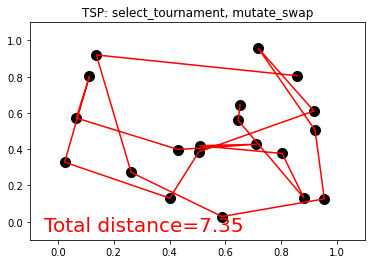

Gen: 11 | best fit: 1520.97


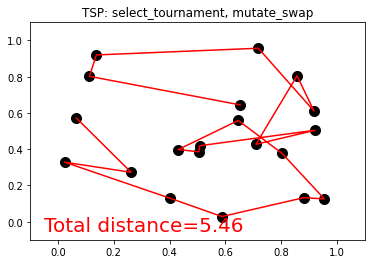

Gen: 22 | best fit: 2216.82


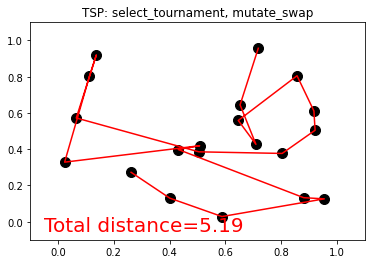

Gen: 33 | best fit: 3833.18


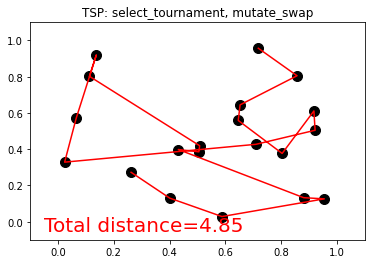

Gen: 44 | best fit: 6663.24


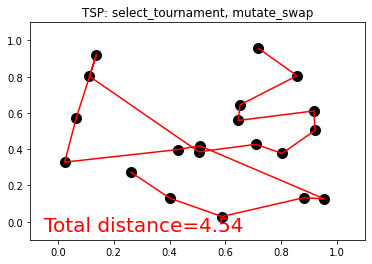

Gen: 55 | best fit: 8025.33


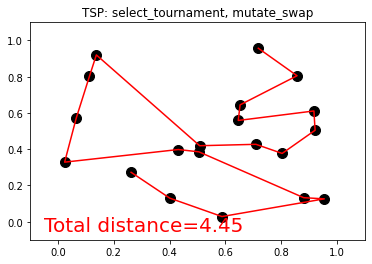

Gen: 66 | best fit: 8067.67


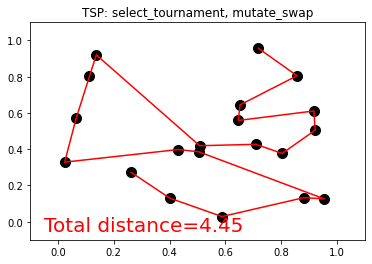

Gen: 77 | best fit: 8067.67


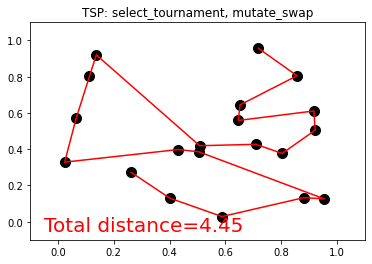

Gen: 88 | best fit: 11413.89


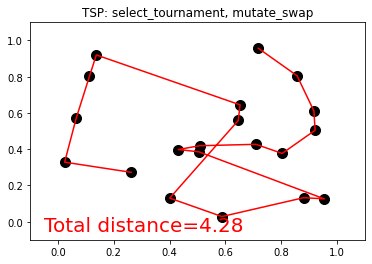

Gen: 99 | best fit: 11413.89


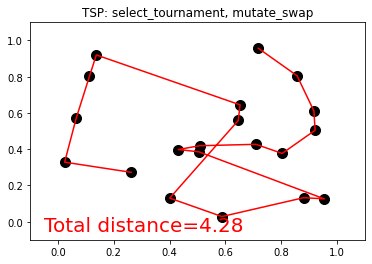

In [ ]:
ga = GA(DNA_size=N_CITIES, cross_rate=combinacion_optima[2], mutation_rate=combinacion_optima[3], pop_size=combinacion_optima[1])

env = TravelSalesPerson(N_CITIES)
for generation in range(N_GENERATIONS):
    # obtiene las coordenadas de las ciudades en orden a la posicion de la ciudad
    lx, ly = ga.translateDNA(ga.pop, env.city_position)
    # calcula el fitness
    fitness, total_distance = ga.get_fitness(lx, ly)
    ga.evolve(fitness=fitness,
              fnSelect=combinacion_optima_ev[1],
              fnCrossover=None,
              fnMutation=combinacion_optima_ev[2])
    best_idx = np.argmax(fitness)
    if generation % 11 == 0:
        print('Gen:', generation, '| best fit: %.2f' % fitness[best_idx],)
        env.plotting(lx[best_idx], ly[best_idx], total_distance[best_idx], f"TSP: {combinacion_optima_ev[1].__name__}, {combinacion_optima_ev[2].__name__}")
plt.ioff()
plt.show()


### 4. Discuta cada uno de sus resultados de forma clara y objetiva, de preferencia use los gráficos obtenidos en las preguntas anteriores. 

El algoritmo genético se busca maximar $e^{\frac{2DNA}{distancia\_total}}$, es decir, al minimizar la distancia recorrida, mas grande es el fitness. Por lo que en las gráfica de la pregunta 2 asociado a la selección del algoritmo genético se seleccionara aquella con mayor función de utilidad de igual modo se hizo en la pregunta 3 para la selección de hiperparámetos. 

Hay una mayor función utilidad con la Selección por Torneo y una mutación por Swap (intercambio). 

Además, antes de la selección de hiperparámetros la gráfica no varia mucho a partir de la generación 66 mientras que después de la selección de hiperparámetros y del algoritmo genético lo hace mucho antes, a partir de 33 generaciones aproximadamente no varía mucho la gráfica de las ciudades y la distancia, por lo que se llega a la solución con un menor número de generaciones después de la optimización de parámetros.